# Trabajo Practico N° 2
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini


In [359]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# Arboles de desición
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Bayes
from sklearn.naive_bayes import MultinomialNB

#KNN
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, mean_absolute_error,
                             mean_squared_error)

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             ConfusionMatrixDisplay, classification_report)

In [277]:
def tableResult(label, prediction):
    table = pd.DataFrame({'Actual':label, 'Predicted':prediction})
    return table

# Primer dataset

In [278]:
dataset1 = pd.read_csv('1000_Companies.csv')

## Análisis exploratorio de datos (EDA)

In [279]:
#Creamos copia del dataset original
df1 = dataset1.copy()

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [280]:
df1.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


**Valores duplicados**

In [281]:
df1.duplicated().values.any()

True

In [282]:
df1 = df1.drop_duplicates()

**Valores faltantes**

In [283]:
df1.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

**Distrubuciones y correlación de las variables**

In [284]:
#Selección de columnas númericas
cols1 = ['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit']

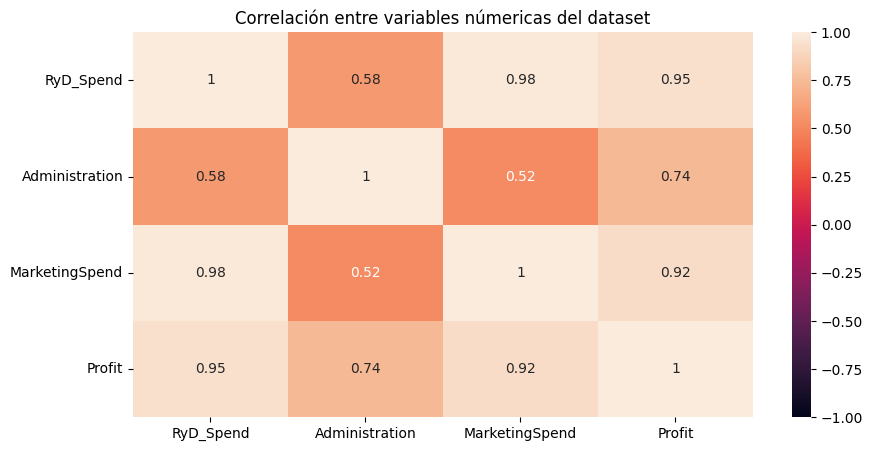

In [285]:
plt.figure(figsize=(10,5))
sns.heatmap(df1[cols1].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

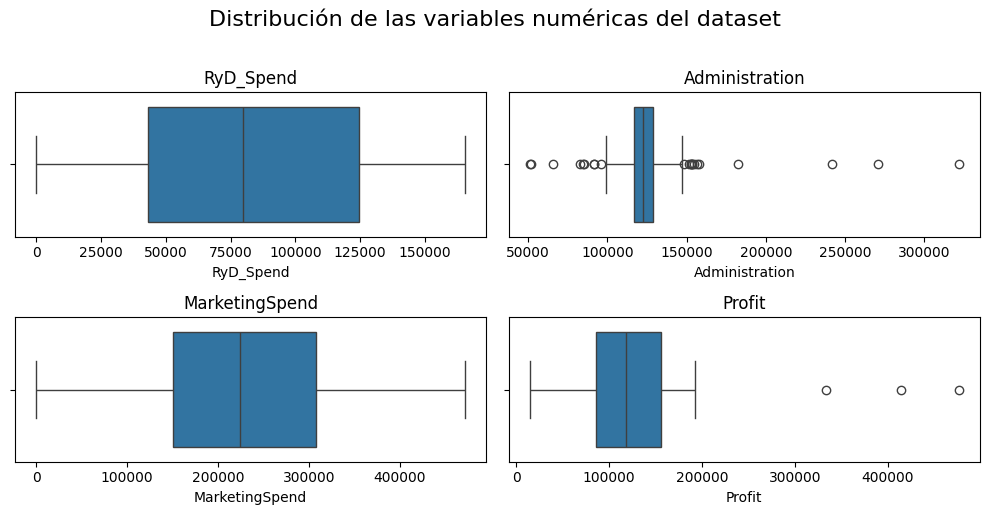

In [286]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

axes = axes.flatten()

for i, col in enumerate(cols1):
    sns.boxplot(x=df1[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Outliers**

In [287]:
df1 = df1[df1['Profit'] < df1['Profit'].quantile(0.997)]

In [288]:
df1 = df1[df1['Administration'] < df1['Administration'].quantile(0.99)]

**Codificación de variables catgorícas**

In [289]:
df1 = pd.get_dummies(data=df1, columns=['State'])

df1

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.8000,471784.1000,192261.83000,False,False,True
2,153441.51,101145.5500,407934.5400,191050.39000,False,True,False
3,144372.41,118671.8500,383199.6200,182901.99000,False,False,True
4,142107.34,91391.7700,366168.4200,166187.94000,False,True,False
5,131876.90,99814.7100,362861.3600,156991.12000,False,False,True
...,...,...,...,...,...,...,...
992,105127.00,125982.7298,271621.8728,138841.98810,False,True,False
993,46798.00,117368.4374,159075.9080,89012.02672,True,False,False
994,97209.00,124813.3635,256344.0701,132077.70900,False,False,True
995,54135.00,118451.9990,173232.6695,95279.96251,True,False,False


In [290]:
df1.columns

Index(['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit',
       'State_California', 'State_Florida', 'State_New York'],
      dtype='object')

**División test - train**

In [291]:
cols_bool = ['State_California', 'State_Florida', 'State_New York']
cols_num = ['RyD_Spend', 'Administration', 'MarketingSpend']

X1 = df1.drop(columns=['Profit'])
y1 = df1['Profit']

X1[cols_bool] = X1[cols_bool].astype('int')

In [292]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size=0.2, random_state=13, shuffle=True)
X_train4, X_test4, y_train4, y_test4  = train_test_split(X1, y1, test_size=0.3, random_state=13, shuffle=True)

## Árbol de decisión

**Optimización del árbol**

In [293]:
param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'random_state': [13]
}
random_search = RandomizedSearchCV(DecisionTreeRegressor(), n_iter=18,
                                   param_distributions=param_grid)
random_search.fit(X_train1, y_train1)
# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
# Entrenamos el modelo con estos hiperparámetros
prediction = random_search.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, prediction))

print(f'{first_best_params} \n {test_rmse}')

{'random_state': 13, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 10, 'criterion': 'friedman_mse'} 
 1685.8849812119781


**Mejor modelo**

In [294]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_reg = DecisionTreeRegressor(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13)

### Dataset 1 (80, 20)

In [295]:
tree_reg.fit(X_train1, y_train1)

,criterion,'friedman_mse'
,splitter,'best'
,max_depth,10
,min_samples_split,7
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [296]:
pred_train = tree_reg.predict(X_train1)

pred_test = tree_reg.predict(X_test1)

tableResult(y_test1, pred_test)

,Actual,Predicted
613,138213.22960,137344.927900
884,63978.72668,63958.010110
811,167391.55140,166945.611317
295,174329.25160,174595.790550
594,54991.58145,54676.347938
...,...,...
423,185028.39680,184901.320950
270,170174.83270,170661.494033
54,89803.10053,90125.381950
496,66273.35330,66873.706558


### Visualización

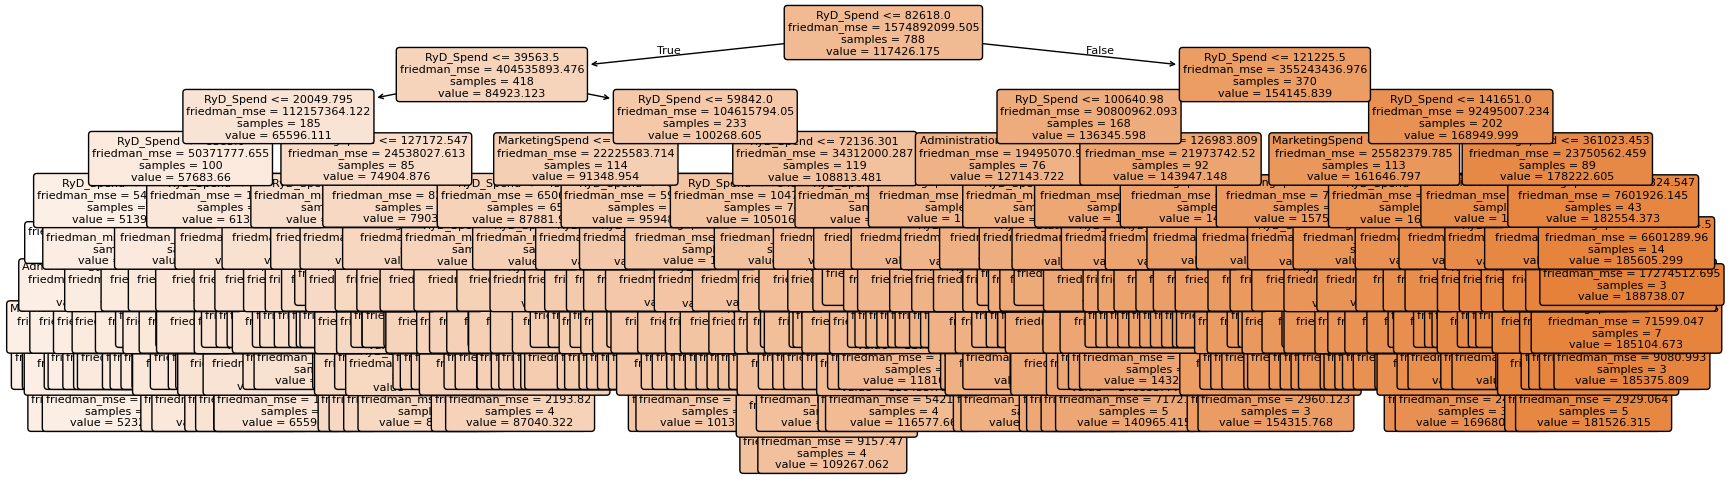

In [297]:
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train1.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

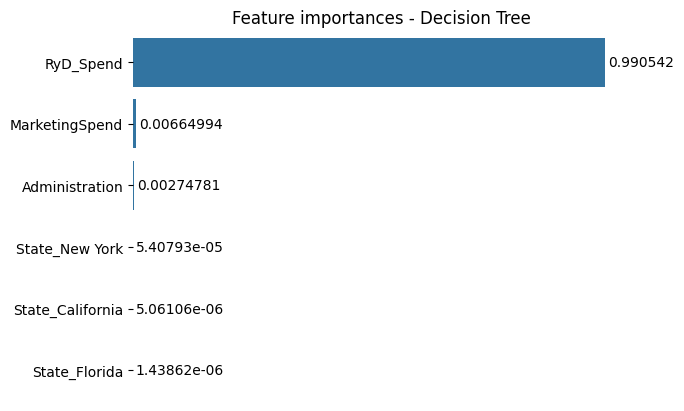

In [298]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train1.columns,
                            'importances': tree_reg.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

### Métricas

In [299]:
mape = np.mean(np.abs((y_test1 - pred_test) / y_test1) * 100)

print('Error absoluto medio:', mean_absolute_error(y_test1, pred_test))
print('Error medio cuadrado:', mean_squared_error(y_test1, pred_test))
print('Raíz del error medio cuadrado:', np.sqrt(mean_squared_error(y_test1, pred_test)))
print("Porcentaje de error medio absoluto (MAPE):", mape)

Error absoluto medio: 682.742084136363
Error medio cuadrado: 2842208.1698761117
Raíz del error medio cuadrado: 1685.8849812119781
Porcentaje de error medio absoluto (MAPE): 0.592609612114148


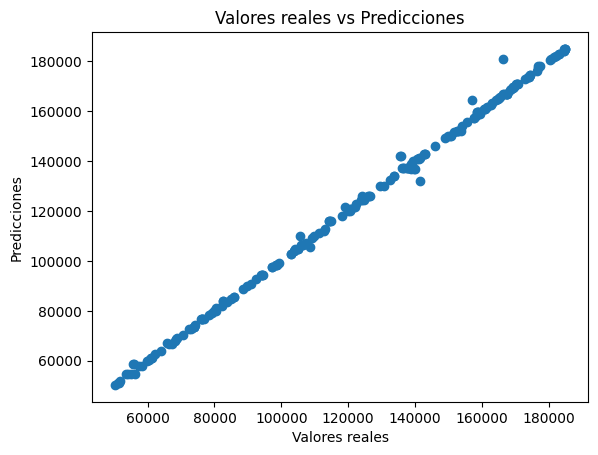

In [300]:
plt.scatter(y_test1, pred_test)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.show()

### Dataset 2 (70, 30)

In [301]:
tree_reg.fit(X_train4, y_train4)

,criterion,'friedman_mse'
,splitter,'best'
,max_depth,10
,min_samples_split,7
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [302]:
pred_train4 = tree_reg.predict(X_train4)

pred_test4 = tree_reg.predict(X_test4)

tableResult(y_test4, pred_test4)

,Actual,Predicted
613,138213.22960,137344.927900
884,63978.72668,64282.854403
811,167391.55140,167014.979780
295,174329.25160,174481.657220
594,54991.58145,55047.964683
...,...,...
853,97955.60308,97581.992985
209,61393.64099,61219.935077
848,109877.23920,109977.191250
580,90482.26217,90561.540410


### Visualización

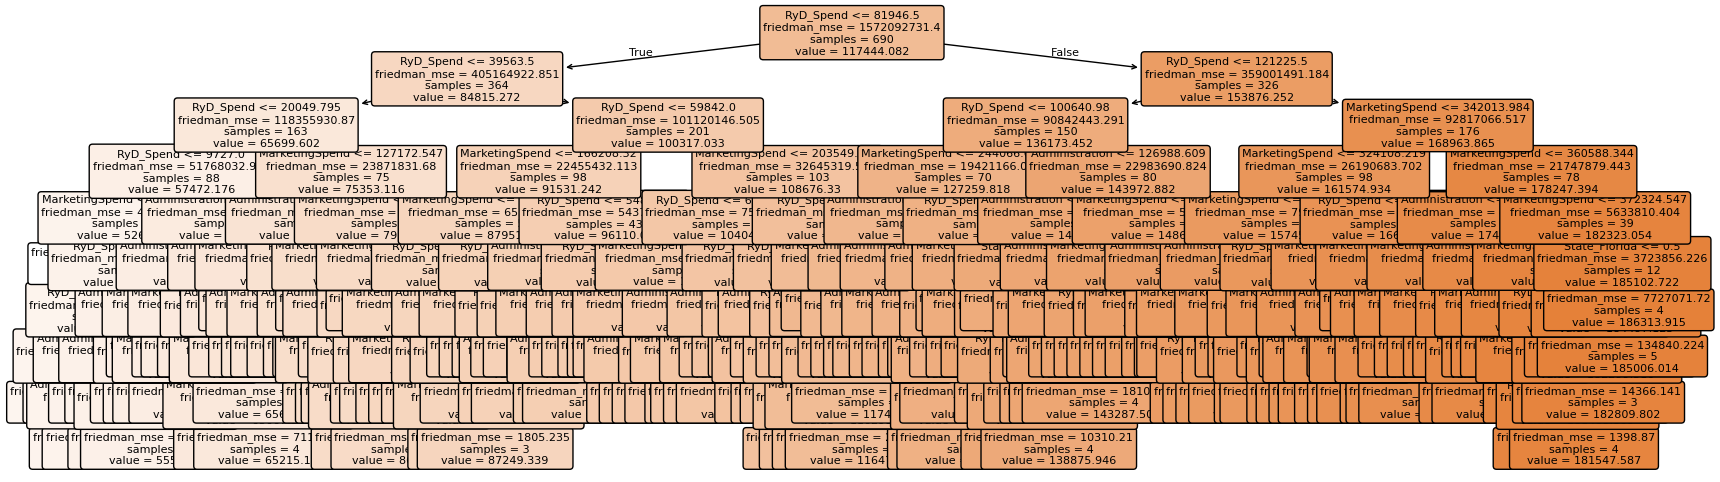

In [303]:
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train4.columns, fontsize=8, filled=True,
            rounded=True)
plt.show()

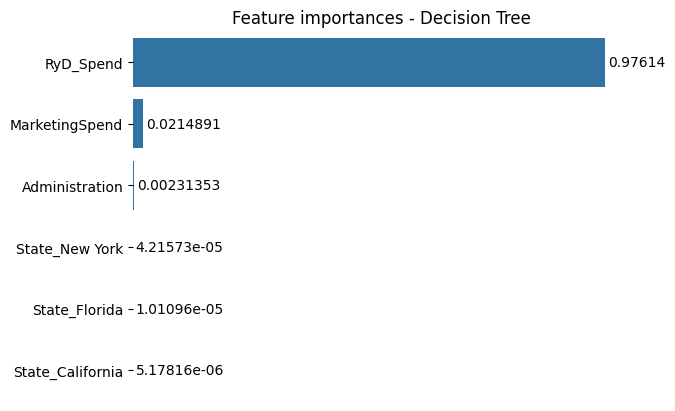

In [304]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train4.columns,
                            'importances': tree_reg.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

### Métricas

In [305]:
mape = np.mean(np.abs((y_test4 - pred_test4) / y_test4) * 100)

print('Error absoluto medio:', mean_absolute_error(y_test4, pred_test4))
print('Error medio cuadrado:', mean_squared_error(y_test4, pred_test4))
print('Raíz del error medio cuadrado:', np.sqrt(mean_squared_error(y_test4, pred_test4)))
print("Porcentaje de error medio absoluto (MAPE):", mape)

Error absoluto medio: 690.9891058147518
Error medio cuadrado: 3952779.0765211415
Raíz del error medio cuadrado: 1988.159721079054
Porcentaje de error medio absoluto (MAPE): 0.5924200658929071


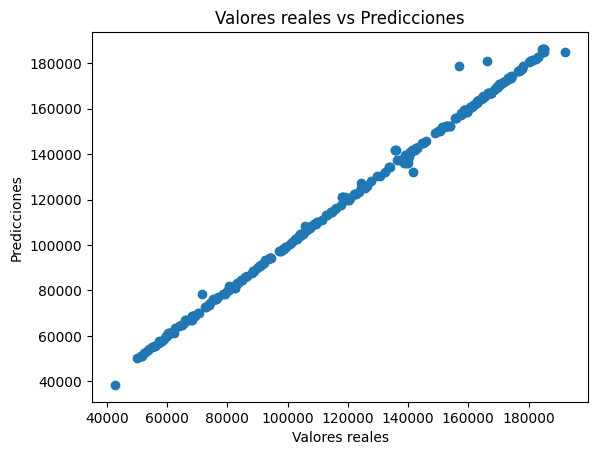

In [306]:
plt.scatter(y_test4, pred_test4)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.show()

# Segundo dataset

In [307]:
dataset2 = pd.read_csv('drugType.csv')

## Análisis exploratorio de datos (EDA)

In [308]:
#Creamos copia del dataset original
df2 = dataset2.copy()

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        200 non-null    int64  
 1   Sexo        200 non-null    object 
 2   BP          200 non-null    object 
 3   Colesterol  200 non-null    object 
 4   Na_a_K      200 non-null    float64
 5   Droga       200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [309]:
df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,F,Alto,Alto,25.355,DrogaY
1,47,M,Bajo,Alto,13.093,DrogaC
2,47,M,Bajo,Alto,10.114,DrogaC
3,28,F,Normal,Alto,7.798,DrogaX
4,61,F,Bajo,Alto,18.043,DrogaY


**Valores duplicados**

In [310]:
df2.duplicated().values.any()

False

**Valores faltantes**

In [311]:
df2.isna().sum()

Edad          0
Sexo          0
BP            0
Colesterol    0
Na_a_K        0
Droga         0
dtype: int64

**Distrubuciones de las variables**

In [312]:
cols2 = ['Na_a_K', 'Edad']

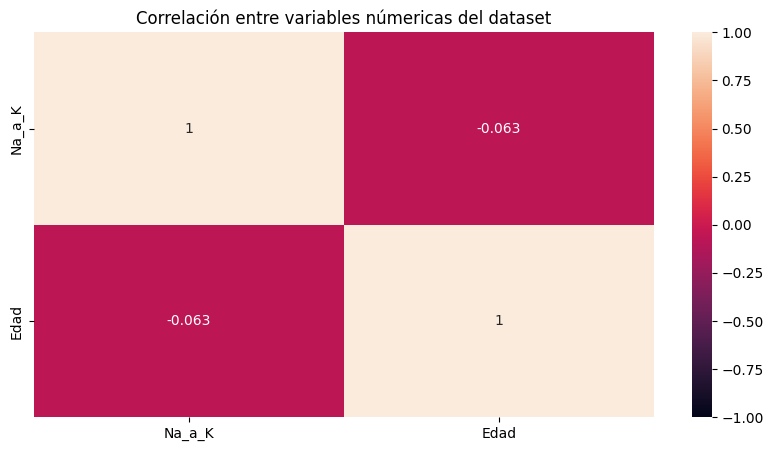

In [313]:
plt.figure(figsize=(10,5))
sns.heatmap(df2[cols2].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

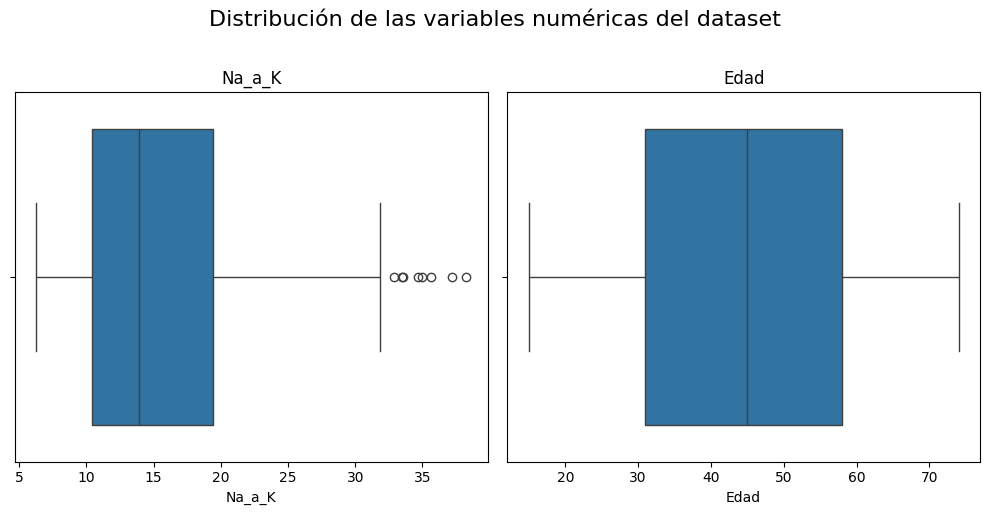

In [314]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes = axes.flatten()

for i, col in enumerate(cols2):
    sns.boxplot(x=df2[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Codificación de variables categóricas**

In [315]:
# Convertir columnas categóricas en numéricas
cat_cols = ['Sexo', 'BP', 'Colesterol']
cat_labels = [df2[col].unique().tolist() for col in cat_cols]
enc = OrdinalEncoder(categories=cat_labels).set_output(transform="pandas")
enc.fit(df2[cat_cols])
df2[cat_cols] = enc.transform(df2[cat_cols])

df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,0.0,0.0,0.0,25.355,DrogaY
1,47,1.0,1.0,0.0,13.093,DrogaC
2,47,1.0,1.0,0.0,10.114,DrogaC
3,28,0.0,2.0,0.0,7.798,DrogaX
4,61,0.0,1.0,0.0,18.043,DrogaY


**División test - train**

In [316]:
X2 = df2.drop(columns=['Droga'])
y2 = df2['Droga']

In [317]:
X_train2, X_test2, y_train2, y_test2  = train_test_split(X2, y2, test_size=0.2, random_state=13, shuffle=True, stratify=y2)
X_train3, X_test3, y_train3, y_test3  = train_test_split(X2, y2, test_size=0.3, random_state=13, shuffle=True, stratify=y2)

**Escalado de datos**

In [318]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 19 to 72
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        40 non-null     int64  
 1   Sexo        40 non-null     float64
 2   BP          40 non-null     float64
 3   Colesterol  40 non-null     float64
 4   Na_a_K      40 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.9 KB


In [319]:
X_train_scaled2 = X_train2.copy()
X_test_scaled2 = X_test2.copy()

scaler = StandardScaler()

X_train_scaled2[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train2[['Edad', 'Na_a_K']])
X_test_scaled2[['Edad', 'Na_a_K']] = scaler.transform(X_test2[['Edad', 'Na_a_K']])

X_train_scaled2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K
83,-0.362829,0.0,0.0,1.0,-0.665798
65,1.453207,0.0,2.0,1.0,1.522411
74,-0.786571,1.0,0.0,1.0,0.133419
7,-0.181225,1.0,1.0,0.0,-0.706016
80,0.968931,1.0,0.0,0.0,-0.302859


In [320]:
X_train_scaled3 = X_train3.copy()
X_test_scaled3 = X_test3.copy()

X_train_scaled3[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train3[['Edad', 'Na_a_K']])
X_test_scaled3[['Edad', 'Na_a_K']] = scaler.transform(X_test3[['Edad', 'Na_a_K']])

X_train_scaled3.head()

,Edad,Sexo,BP,Colesterol,Na_a_K
39,-1.725205,1.0,2.0,0.0,-0.990332
129,-0.699477,0.0,2.0,0.0,-1.222585
71,-0.940825,0.0,2.0,0.0,0.540342
174,-0.096108,1.0,0.0,1.0,-0.458187
125,-1.483857,0.0,0.0,1.0,1.449988


In [321]:
X_train_scaled2.shape, X_test_scaled2.shape, X_train_scaled3.shape, X_test_scaled3.shape

((160, 5), (40, 5), (140, 5), (60, 5))

## Árbol de decisión

**Optimización de hiperparámetros**

In [322]:
param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15],
    'criterion': ['entropy', 'log_loss', 'gini'],
    'random_state': [13]
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), n_iter=18,
                                   param_distributions=param_grid)
random_search.fit(X_train2, y_train2)
# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
# Entrenamos el modelo con estos hiperparámetros
best_prediction = random_search.predict(X_test2)
test_accuracy = accuracy_score(y_test2, best_prediction)

print(f'{first_best_params} \n {test_accuracy}')

{'random_state': 13, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'entropy'} 
 0.975


**Mejor modelo**

In [323]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_clf = DecisionTreeClassifier(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13, 
                                  class_weight= 'balanced')

### Dataset 1: (80, 20)

In [324]:
tree_clf.fit(X_train2, y_train2)

,criterion,'entropy'
,splitter,'best'
,max_depth,15
,min_samples_split,7
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [325]:
pred_train = tree_clf.predict(X_train2)

pred_test2 = tree_clf.predict(X_test2)

tableResult(y_test2, pred_test2).head()

,Actual,Predicted
19,DrogaY,DrogaY
50,DrogaY,DrogaY
99,DrogaY,DrogaY
41,DrogaB,DrogaB
30,DrogaX,DrogaX


**Visualización**

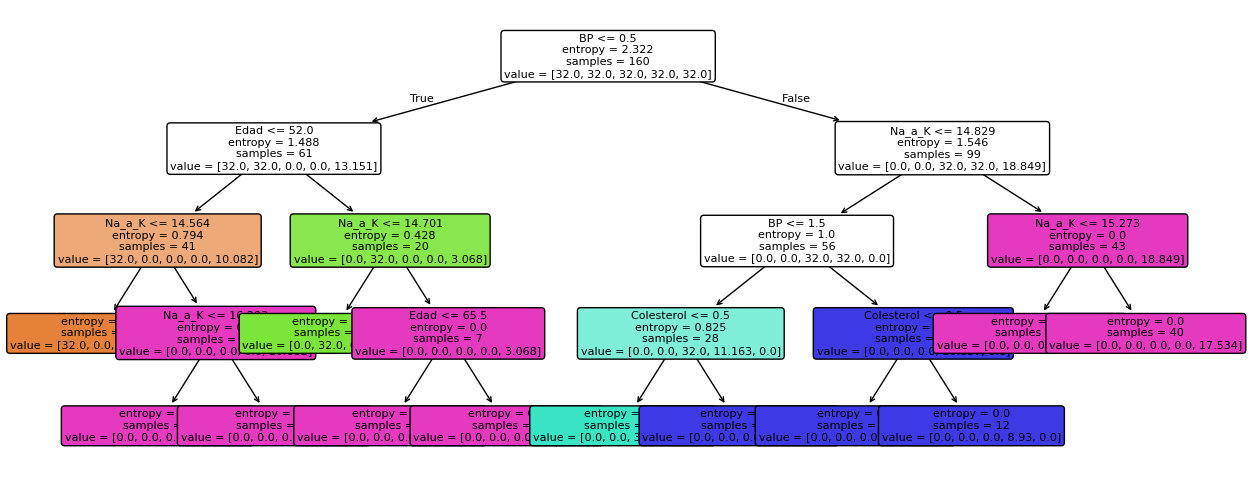

In [326]:
plt.figure(figsize=(15,6))
plot_tree(tree_clf, feature_names=X_train2.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

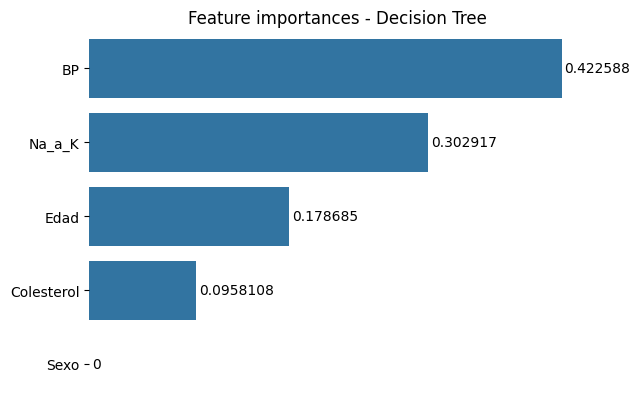

In [327]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train2.columns,
                            'importances': tree_clf.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

**Métricas**

In [328]:
print('Accuracy:', accuracy_score(y_test2, pred_test2))
print('Presision:', precision_score(y_test2, pred_test2, average='weighted'))
print('Recall:', recall_score(y_test2, pred_test2, average='weighted'))
print("F1:", f1_score(y_test2, pred_test2, average='weighted'))

Accuracy: 0.975
Presision: 0.9791666666666667
Recall: 0.975
F1: 0.9736363636363636


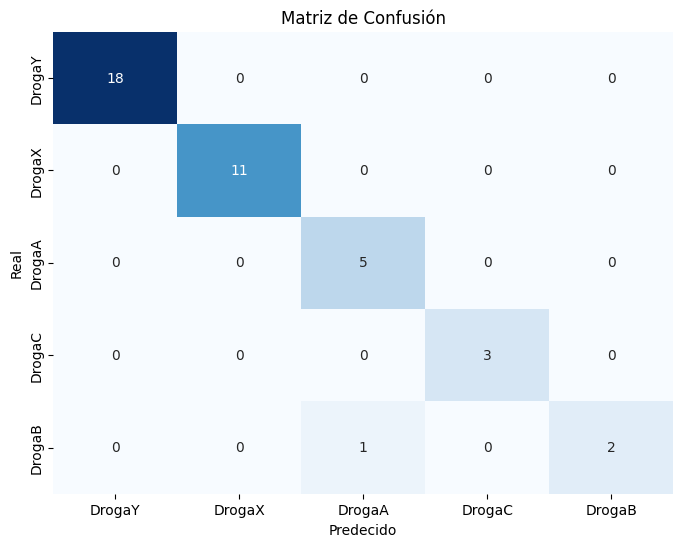

In [329]:
confusion = confusion_matrix(y_test2, pred_test2, labels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            yticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            cbar=False)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Dataset 2: (70, 20)

In [330]:
tree_clf.fit(X_train3, y_train3)

,criterion,'entropy'
,splitter,'best'
,max_depth,15
,min_samples_split,7
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [331]:
pred_train3 = tree_clf.predict(X_train3)

pred_test3 = tree_clf.predict(X_test3)

tableResult(y_test3, pred_test3).head()

,Actual,Predicted
93,DrogaY,DrogaY
35,DrogaX,DrogaX
150,DrogaA,DrogaA
152,DrogaX,DrogaX
137,DrogaA,DrogaA


**Visualización**

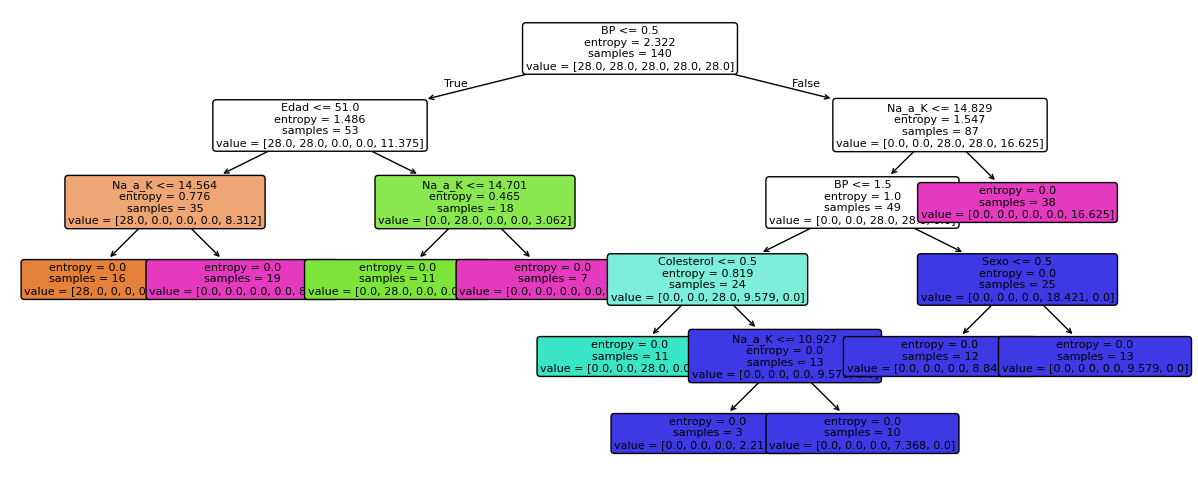

In [332]:
plt.figure(figsize=(15,6))
plot_tree(tree_clf, feature_names=X_train3.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

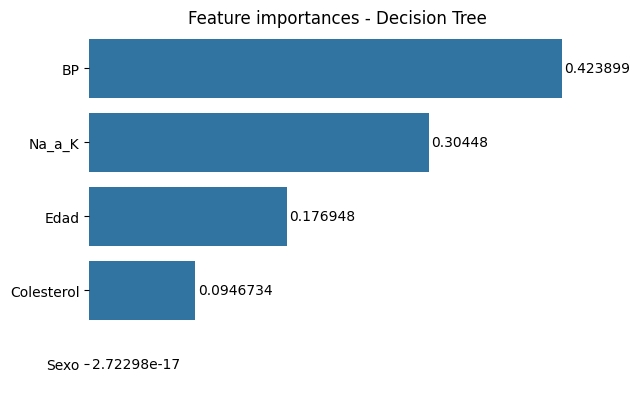

In [333]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train3.columns,
                            'importances': tree_clf.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

**Métricas**

In [334]:
print('Accuracy:', accuracy_score(y_test3, pred_test3))
print('Presision:', precision_score(y_test3, pred_test3, average='weighted'))
print('Recall:', recall_score(y_test3, pred_test3, average='weighted'))
print("F1:", f1_score(y_test3, pred_test3, average='weighted'))

Accuracy: 0.9833333333333333
Presision: 0.9854166666666667
Recall: 0.9833333333333333
F1: 0.9829629629629629


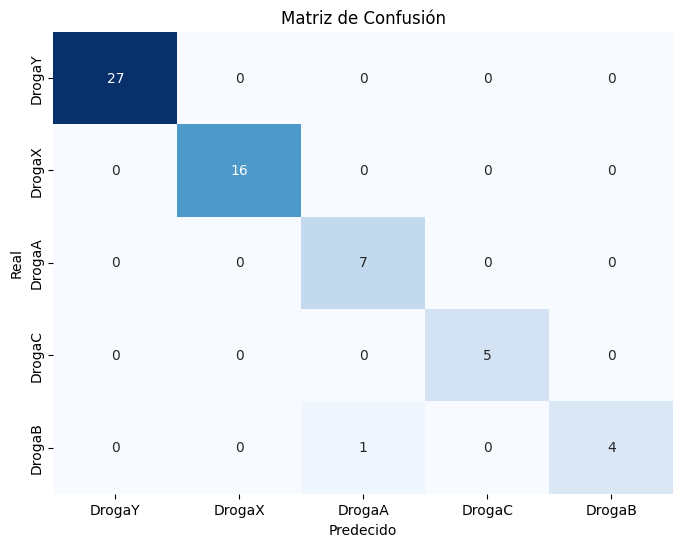

In [335]:
confusion = confusion_matrix(y_test3, pred_test3, labels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            yticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            cbar=False)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [336]:
X_train3

,Edad,Sexo,BP,Colesterol,Na_a_K
39,15,1.0,2.0,0.0,9.084
129,32,0.0,2.0,0.0,7.477
71,28,0.0,2.0,0.0,19.675
174,42,1.0,0.0,1.0,12.766
125,19,0.0,0.0,1.0,25.969
...,...,...,...,...,...
153,72,0.0,1.0,1.0,14.642
151,68,1.0,0.0,0.0,11.009
159,34,0.0,1.0,1.0,12.923
157,53,1.0,1.0,0.0,22.963


# Multinomial Naïve Bayes

### Dataset 1 (80, 20)

In [337]:
X_train2['Edad'] = pd.qcut(X_train2['Edad'], q=4, labels=False)
X_test2['Edad'] = pd.qcut(X_test2['Edad'], q=4, labels=False)

In [338]:
X_train2['Na_a_K'] = pd.qcut(X_train2['Na_a_K'], q=4, labels=False)
X_test2['Na_a_K'] = pd.qcut(X_test2['Na_a_K'], q=4, labels=False)

**Modelo**

In [ ]:
clf_MNB = MultinomialNB()
clf_MNB.fit(X_train2, y_train2)

pred_MNB2 = clf_MNB.predict(X_test2)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


**Métricas**

In [348]:
precision_MNB = precision_score(y_test2, pred_MNB2, average='weighted')
accuracy_MNB = accuracy_score(y_test2, pred_MNB2)
recall_MNB = recall_score(y_test2, pred_MNB2, average='weighted')

print(f'Precision: {precision_MNB}')
print(f'Accuracy: {accuracy_MNB}')
print(f'Recall: {recall_MNB}');

Precision: 0.6590384615384616
Accuracy: 0.725
Recall: 0.725


c:\Users\juana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


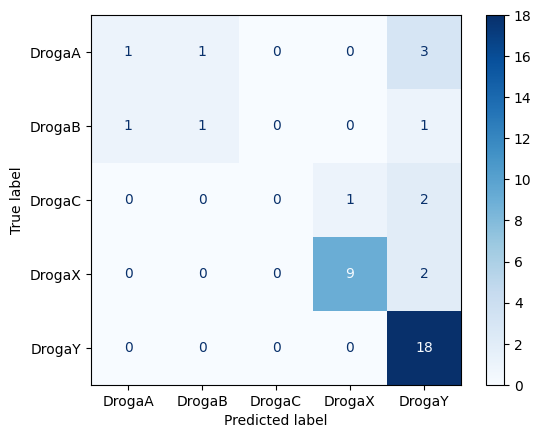

In [356]:
ConfusionMatrixDisplay.from_predictions(y_test2, pred_MNB2, cmap=plt.cm.Blues)

### Dataset 2 (70, 20)

In [351]:
X_train3['Edad'] = pd.qcut(X_train3['Edad'], q=4, labels=False)
X_test3['Edad'] = pd.qcut(X_test3['Edad'], q=4, labels=False)

In [352]:
X_train3['Na_a_K'] = pd.qcut(X_train3['Na_a_K'], q=4, labels=False)
X_test3['Na_a_K'] = pd.qcut(X_test3['Na_a_K'], q=4, labels=False)

**Modelo**

In [353]:
clf_MNB = MultinomialNB()
clf_MNB.fit(X_train3, y_train3)

pred_MNB3 = clf_MNB.predict(X_test3)

**Métricas**

In [354]:
precision_MNB = precision_score(y_test3, pred_MNB3, average='weighted')
accuracy_MNB = accuracy_score(y_test3, pred_MNB3)
recall_MNB = recall_score(y_test3, pred_MNB3, average='weighted')

print(f'Precision: {precision_MNB}')
print(f'Accuracy: {accuracy_MNB}')
print(f'Recall: {recall_MNB}');

Precision: 0.6578493999225706
Accuracy: 0.7166666666666667
Recall: 0.7166666666666667


c:\Users\juana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


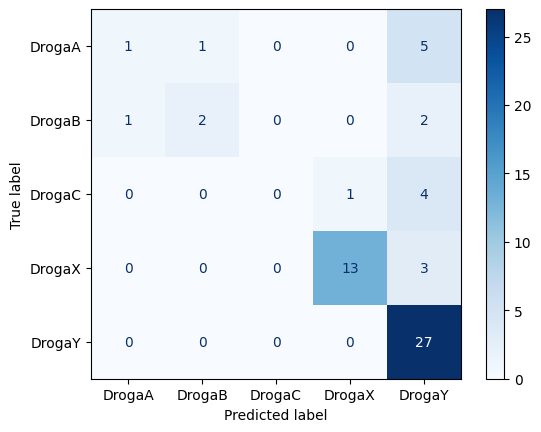

In [357]:
ConfusionMatrixDisplay.from_predictions(y_test3, pred_MNB3, cmap=plt.cm.Blues)

# KNN

### Dataset 1 (80, 20)

In [360]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train2, y_train2)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [361]:
predictions = knn.predict(X_test2)

Precisión del modelo: 0.82

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.67      0.80      0.73         5
      DrogaB       0.50      0.33      0.40         3
      DrogaC       0.50      0.33      0.40         3
      DrogaX       0.91      0.91      0.91        11
      DrogaY       0.89      0.94      0.92        18

    accuracy                           0.82        40
   macro avg       0.69      0.66      0.67        40
weighted avg       0.81      0.82      0.81        40



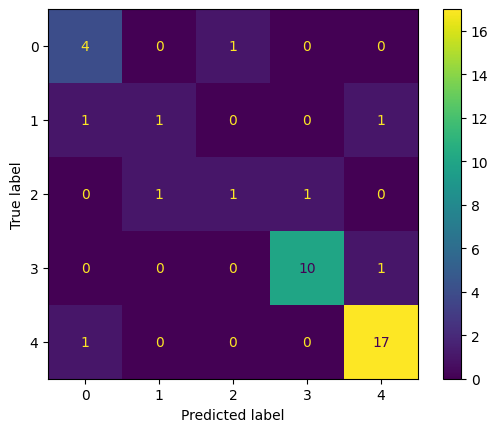

In [364]:
cm_knn = confusion_matrix(y_test2, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot()

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test2, predictions)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(y_test2, predictions))

### Dataset 2 (70, 30)